# Note:
### - New or modified parts of code are marked with "#"

# Homework:

Make plots (for 1 simulation):
### 1) utilization (4 bars)
- of Alice time with and witout Storage (what is percentage of time that Alice is waitng for Bob)
- of Bob's time with and witout Storage (what is percentage of time that Bob is waitng for Alice)
### 2) storage usage over time 

Use either Python or Julia

Provide code + 2 pictures (png format)

- if Alice has storage --> she doesn't wait. So, if there is a storage, than her utilization is 100% time
- Bob can wait because there are no boxes in the storage

utilization if the opposite of how much it's idle (100% of usage = 0% of waiting)

1 of bars is easy for sure:
- when there is a storage --> Alice doesn't for Bob and just starts a new box, hence her utilization is 100%

**but the question here is rather**: how much time she is actually spending working when there is no storage?

In [ ]:
import numpy as np
import numpy.random as rd

time_bob = np.array([ #[time, empirical; number of observations]
  [10 , 4],
  [20 , 6],
  [30 , 10],
  [40 , 20],
  [50 , 40],
  [60 , 11],
  [70 , 5],
  [80 , 4]
]) 

time_alice = np.array([ #[time, empirical; number of observations]
  [10 , 4],
  [20 , 5],
  [30 , 6],
  [40 , 7],
  [50 , 10],
  [60 , 8],
  [70 , 6],
  [80 , 2]       
])

print(time_bob)
print(time_bob.shape)

In [ ]:
def min_vals(*args):
    vals = [v for v in args if v is not None]
    if len(vals)==0:
        return None
    return min(vals)

assert min_vals(1,2,3) == 1
assert min_vals(4,2,None) == 2
assert min_vals(None,None,None) == None

In [ ]:
class ProductionLine:
    alice_action_end = 0  # time measured in seconds
    bob_action_end = None   
    alice_has_box = False #Alice holds or prepares box for Bob
    bob_has_box = False   #Bob works with box
    
#     storage_active = True ## to control scenario
    storage_counter = 0 ## number of boxes which are currently in the storage ##
#     there_is_a_box_in_storage = storage_counter > 0 ## False by default at the beginning of Simulation REDUNDANT?
    
    tick  = 0       # simulation step
    clock = 0       # time in simulated world in seconds
    clock_points = [] ##
    completed_boxes = 0 # completed boxes
    
#  ## {alice_waiting_time : bob_st_cumulative_waiting_time}
    alice_waiting_time = 0
    alice_cumulative_waiting_time = 0
    bob_waiting_time = 0
    bob_cumulative_waiting_time = 0
    
#     bob_st_waiting_time = 0
#     bob_st_cumulative_waiting_time = 0

    def __init__(self,time_bob,time_alice,storage_active): #constructor
        self.time_alice = time_alice
        self.time_bob = time_bob        
        self.p_time_alice = time_alice[:,1]/np.sum(time_alice[:,1])
        self.p_time_bob = time_bob[:,1]/np.sum(time_bob[:,1]) 
        self.storage_active = storage_active
    
    def step(self):
        #Selecting the next event to happen
        # Calculating the time of the next event to happen
        # Check if this event triggers another conditional action such as leaving the queue
        
        #Alice & Bob
        #Unconditional events: Alice completed job, Bob completed job
        #Conditional events: 
        # - Alice starts job (needs to have free hands)
        # - Bob starts job (needs to have free hands and a box must be available)
        
        #unconditional event
        self.clock = min_vals(self.alice_action_end,self.bob_action_end)
        
        # 1st scenario: Alice has a box the box but she needs to wait for a Bob
        if self.alice_has_box and self.bob_action_end is not None and self.bob_action_end > self.alice_action_end:
           ## if storage is active --> put finished box in a storage and start a new one:
            if self.storage_active:
                self.storage_counter += 1 ## (can be written without else here)
                self.alice_has_box = False
                print(f"there are {self.storage_counter} boxes in storage")
                self.alice_cumulative_waiting_time = 0
            ## Alice waiting for Bob condition (for no storage)
            elif not self.storage_active:
                self.alice_waiting_time = (self.bob_action_end - self.alice_action_end) ## Alice waiting time on step
                self.alice_cumulative_waiting_time += self.alice_waiting_time
                print(f"ALICE NEEDS TO WAIT FOR A BOB {self.alice_waiting_time} SECONDS. HER CUMULATIVE WAITING TIME NOW = {self.alice_cumulative_waiting_time}")
                self.clock = self.bob_action_end 
        
        # 2nd scenario: Alice is free and not doing anything --> then she takes a box
        if not self.alice_has_box:
            self.alice_has_box = True
            self.alice_action_end = self.clock + \
                    rd.choice(self.time_alice[:,0],p=self.p_time_alice)
            print(self.clock, "Alice starts doing new box for the time ", self.alice_action_end)

        # 3nd scenario: if Bob has box in his hands and he has just finished manufacturing the box
        if self.bob_has_box and self.bob_action_end <= self.clock:
            print(self.clock, "Bob finishes the box")
            self.completed_boxes += 1
            self.bob_action_end = None
            self.bob_has_box = False
        
       ## 5th scnario: Bob waiting for Alice condition (5th goes right after 3rd!?)
        ###
        if self.bob_action_end is None and self.clock < self.alice_action_end and self.clock > 0:
            # here should be a condition for storage?
            if self.storage_active:
                if self.storage_counter > 0:
                    ## take a box from storage
                    self.storage_counter -= 1
                    print(f"there are {self.storage_counter} boxes in storage")
                    self.bob_has_box = True
    #                 self.bob_action_end = 
    #                 self.bob_waiting_time =
    #                 self.bob_cumulative_waiting_time = 
#                 elif self.storage_counter == 0
                    
            elif not self.storage_active:
                self.bob_waiting_time = (self.alice_action_end - self.clock)
                self.bob_cumulative_waiting_time += (self.alice_action_end - self.clock)
                print(f"BOB NEEDS TO WAIT FOR ALICE {self.bob_waiting_time} SECONDS. HIS CUMULATIVE WAITING TIME NOW = {self.bob_cumulative_waiting_time}")
                
            
        # 4th scenario: if Alice has a box and Alice has finished a job --> Alice is ready to pass the box to Bob
        if self.alice_has_box and (self.alice_action_end is None or self.alice_action_end <= self.clock):
            print(self.clock, "Alice is ready to pass box to Bob ")
            if not self.bob_has_box:            
                self.bob_action_end = self.clock + \
                   rd.choice(self.time_bob[:,0],p=self.p_time_bob)
                print(self.clock, "Bob takes the box from Alice and will be ready at ",self.bob_action_end)
                self.bob_has_box = True
                self.alice_has_box = False
        
        self.tick = self.tick + 1 #increase step size
        self.clock_points.append(self.clock)
        
        
    def status(self):
        print("### tick =",self.tick,"clock =",self.clock,"Alice has box", self.alice_has_box,"Alice end =",
              self.alice_action_end,
              "Bob end =",self.bob_action_end, "Bob has box =",self.bob_has_box,
              "completed_boxes =",self.completed_boxes)
        

In [362]:
# ProductionLine.storage_active = False ## SWITCH HERE
# ProductionLine.storage_active
# storage_active_values = [False, True]

In [373]:
rd.seed(10)
# Starting the model
m = ProductionLine(time_bob, time_alice, storage_active=True)  # Creating the object with ___init___ constructor
for step in range(40):  
    m.step()
    m.status()

0 Alice starts doing new box for the time  60
### tick = 1 clock = 0 Alice has box True Alice end = 60 Bob end = None Bob has box = False completed_boxes = 0
60 Alice is ready to pass box to Bob 
60 Bob takes the box from Alice and will be ready at  70
### tick = 2 clock = 60 Alice has box False Alice end = 60 Bob end = 70 Bob has box = True completed_boxes = 0
60 Alice starts doing new box for the time  110
### tick = 3 clock = 60 Alice has box True Alice end = 110 Bob end = 70 Bob has box = True completed_boxes = 0
70 Bob finishes the box
### tick = 4 clock = 70 Alice has box True Alice end = 110 Bob end = None Bob has box = False completed_boxes = 1
110 Alice is ready to pass box to Bob 
110 Bob takes the box from Alice and will be ready at  160
### tick = 5 clock = 110 Alice has box False Alice end = 110 Bob end = 160 Bob has box = True completed_boxes = 1
110 Alice starts doing new box for the time  160
### tick = 6 clock = 110 Alice has box True Alice end = 160 Bob end = 160 Bob 

TypeError: '>=' not supported between instances of 'int' and 'NoneType'

In [374]:
# for storage_active in storage_active_values:
#     m = ProductionLine(time_bob, time_alice, storage_active)
#     for step in range(40):  
#         m.step()
#         m.status()
#     print(f"- clock = {m.clock}") ##
#     if m.storage_active:
#         print(f"Alice cumulative waiting time with storage = {m.alice_cumulative_waiting_time}") 
#         print(f"Bob cumulative waiting time with storage = {m.bob_cumulative_waiting_time}")
#         alice_working_time_with_storage = m.clock - m.alice_cumulative_waiting_time ## always == m.clock (m.clock - 0)
#         bob_working_time_with_storage = m.clock - m.bob_cumulative_waiting_time
#         print(f"Alice working time with storage = {alice_working_time_with_storage}")
#         print(f"Bob working time with storage = {bob_working_time_with_storage}")
#     elif not m.storage_active:
#         print(f"Alice cumulative waiting time without storage = {m.alice_cumulative_waiting_time}")
#         print(f"Bob cumulative waiting time without storage = {m.bob_cumulative_waiting_time}")
#         alice_working_time_without_storage = m.clock - m.alice_cumulative_waiting_time
#         bob_working_time_without_storage = m.clock - m.bob_cumulative_waiting_time
#         print(f"Alice working time without storage = {alice_working_time_without_storage}")
#         print(f"Bob working time without storage = {bob_working_time_without_storage}")

In [375]:
print(f"- clock = {m.clock}") ##

if m.storage_active:
    print(f"Alice cumulative waiting time with storage = {m.alice_cumulative_waiting_time}") 
    print(f"Bob cumulative waiting time with storage = {m.bob_cumulative_waiting_time}")
    alice_working_time_with_storage = m.clock - m.alice_cumulative_waiting_time ## always == m.clock (m.clock - 0)
    bob_working_time_with_storage = m.clock - m.bob_cumulative_waiting_time
    print(f"Alice working time with storage = {alice_working_time_with_storage}")
    print(f"Bob working time with storage = {bob_working_time_with_storage}")
elif not m.storage_active:
    print(f"Alice cumulative waiting time without storage = {m.alice_cumulative_waiting_time}")
    print(f"Bob cumulative waiting time without storage = {m.bob_cumulative_waiting_time}")
    alice_working_time_without_storage = m.clock - m.alice_cumulative_waiting_time
    bob_working_time_without_storage = m.clock - m.bob_cumulative_waiting_time
    print(f"Alice working time without storage = {alice_working_time_without_storage}")
    print(f"Bob working time without storage = {bob_working_time_without_storage}")

- clock = 250
Alice cumulative waiting time with storage = 0
Bob cumulative waiting time with storage = 0
Alice working time with storage = 250
Bob working time with storage = 250


In [376]:
utility = {"Alice without storage": alice_working_time_without_storage, "Alice with storage": alice_working_time_with_storage,
           "Bob without storage": bob_working_time_without_storage ,"Bob with storage": bob_working_time_with_storage}

In [377]:
utility # 3 out of 4 correct? Only "Bob with storage" left

{'Alice without storage': 600,
 'Alice with storage': 250,
 'Bob without storage': 850,
 'Bob with storage': 250}

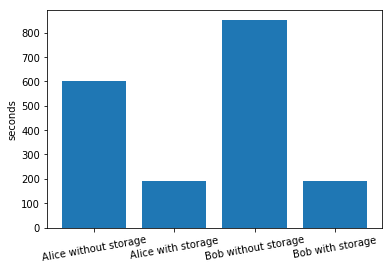

In [249]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots() 
names = list(utility.keys())
values = list(utility.values())
plt.bar(range(len(utility)),values,tick_label=names)
plt.xticks(rotation=10)
ax.set_title('Alice and Bob utilization (working time)')
plt.ylabel('seconds')
plt.savefig('utilization.png')
plt.show()

### Overall storage time is just Alice waiting time + Bob waiting time? Or not? If yes --> 310 + 50 = 360

In [43]:
# storage = m.alice_cumulative_waiting_time + m.bob_cumulative_waiting_time
# storage

In [44]:
storage_time_points = np.unique(m.clock_points)
storage_time_points

array([  0,  60,  70, 110, 160, 190, 200, 210, 250, 270, 280, 340, 390,
       400, 440, 470, 480, 520, 530, 560, 600, 610, 650, 660, 700, 710,
       760, 810, 830, 850, 870, 910])

In [45]:
m.box_added_to_storage

12